In [1]:
push!(LOAD_PATH, "./../src/")

using Images, TestImages
using ApApproximation

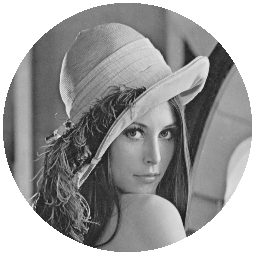

In [2]:
function load_testimage(name::AbstractString)
    img = testimage(name) |> x->convert(Array{Float64,2}, data(x))
    circle(i,j) = (i-size(img,1)/2)^2 + (j-size(img,1)/2)^2 <= (min(size(img)...)/2)^2*.95
    C = eltype(img)[circle(i,j) for i in 1:size(img,1), j in 1:size(img,2)]
    C.*img + (1-C)
end

img = load_testimage("lena_gray_256")
convert(Image, img)

In [4]:
N = 6
@time E = generate_set(N, 6);

println("Size of the set E: (Q,N) = $(size(E))")

  9.142800 seconds (56.14 M allocations: 1.066 GB, 1.39% gc time)
Size of the set E: (Q,N) = (1106,6)


Started interpolation
  0.017952 seconds (109.08 k allocations: 3.184 MB)
Started inverse interpolation
  0.049327 seconds (307.55 k allocations: 8.590 MB, 11.82% gc time)


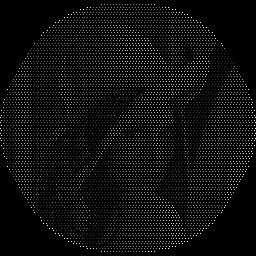

In [9]:
# approximation of the set E
println("Started interpolation")
@time f = cartesian2bispectral(img, E); 

println("Started inverse interpolation")
# convert(Image, bispectral2cart(f1))
@time a = evaluate2cart(f)

convert(Image, clamp(a, 0, 1)')

In [10]:
quarter = round(Int,size(E,1)/4)
α = 100
d = [   ones(2quarter)*α/10; 
        ones(quarter)*α; 
        ones(size(E,1) - 3*quarter)*1e2α; ]

println("Generating Bessel matrices: ")
@time J = BesselMatrix(E, E, weights = d);

# @time J = BesselMatrix(E);

Generating Bessel matrices: 
 50.185757 seconds (200.04 M allocations: 7.616 GB, 16.44% gc time)


In [11]:
ap(f, J) ## Dry run for compilation
@time af = ap(f, J);

println("The size of af is $(size(af))")

println()
println("Norm: $(norm(vec(af.f),2) |> x->round(x,2))")
println()

diff = norm(vec(af.f))/norm(vec(f.f)) |> x->round(x,2) #|> log10 |> x->round(x,1)
# println("L^2 norm of the resulting AP approximation $(round(Int,norm(vec(af.f),2)/norm(f.f,2)*100))% of the norm of the image")

  3.544188 seconds (148.75 k allocations: 512.830 MB, 5.30% gc time)
The size of af is (1106,6)

Norm: 0.3



0.01

  0.292478 seconds (243.95 k allocations: 124.832 MB, 8.04% gc time)


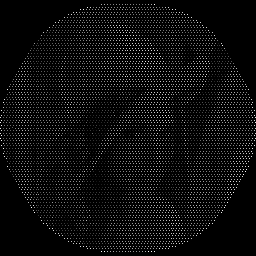

In [12]:
@time f_int = iap(af, E, J)
convert(Image, clamp(evaluate2cart(f_int), 0, 1)')

  0.173093 seconds (314.55 k allocations: 124.590 MB, 12.37% gc time)

Norm: 44.52

Maximal and minimum values of the resulting image: (-0.39832412003447615,1.4484780930609749)


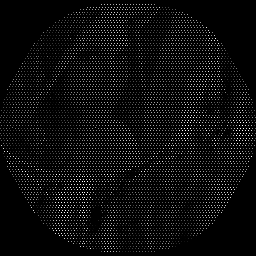

In [15]:
ρ = 30.
θ = pi/3

@time f_trans = translate(af, ρ, θ) |> x -> iap(x, E, J)

println()
println("Norm: $(norm(vec(f_trans.f),2) |> x->round(x,2))")
println()

extr = extrema(evaluate2cart(f_trans))
println("Maximal and minimum values of the resulting image: $extr")

I = convert(Image, clamp(evaluate2cart(f_trans), 0, 1)')

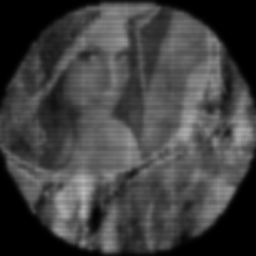

In [16]:
imfilter_gaussian(I*5,[2.5,2.5])